# Storing spatial-omics data from various technologies using SpatialData

From previous part, you have learned to use [AnnData](https://anndata.readthedocs.io/en/stable/#) to organize matrices together with additional information on the observations (e.g. spots, cells, molecules) and/ or features (e.g. genes, proteins or metabolites). [SpatialData](https://spatialdata.scverse.org/en/stable/index.html) is another data storing package, that focuses on spatial omics data from various sources, differing in resolution, molecule type etc..., providing a data container to load the data into a unified framework to work on. In addition, SpatialData provides a vast set of functions to work on the data directly and visualisation tools.

In this session, you will learn the basic functionalities of SpatialData, such as basic plotting, querying and aggregation.

**References:**

* [SpatialData: an open and universal data framework for spatial omics](https://www.nature.com/articles/s41592-024-02212-x)
* https://spatialdata.scverse.org/en/stable/tutorials/notebooks/notebooks/examples/spatial_query.html
* https://spatialdata.scverse.org/en/stable/tutorials/notebooks/notebooks/examples/aggregation.html
* https://spatialdata.scverse.org/en/latest/tutorials/notebooks/notebooks/examples/technology_xenium.html

In [1]:
import warnings
import scanpy as sc
import spatialdata as sd
import spatialdata_plot  # noqa: F401
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from spatialdata.io import xenium
from spatialdata import bounding_box_query, to_circles, to_polygons
from spatialdata_plot.pl.utils import set_zero_in_cmap_to_transparent

warnings.filterwarnings("ignore")

/Users/wangjunhu/miniconda/envs/spatialdata/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/Users/wangjunhu/miniconda/envs/spatialdata/lib/python3.10/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/Users/wangjunhu/miniconda/envs/spatialdata/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.w

## SpatialData Introduction



**Task 1** What 5 data elements are used in SpatialData. If you think of your previous days, excercises, which results / parts would you put in which element container?

## Load the lung cancer Xenium dataset and explore the the SpatialData object, what can you find?


With imaging-based technologies, you either have a setting with one channel equalling one feature, such in CODEX or multiple images encoding a RNA species, after decoding giving the position of a RNA molecule. In this tutorial, we will use a Xenium dataset provided by the [SpatialData library](https://spatialdata.scverse.org/en/stable/tutorials/notebooks/datasets/README.html). Xenium is based on padlock probes, followed by a rolling circel amplification, after decoding, will give us RNA coordinates. 

In addition many, of these experimental methods provide, nucleus staining or cell membrane staining to enhance cell segmentation, giving a clue about the shapes of cells. 


In this tutorial, we will use a Xenium dataset, which we downloaded based on the (script)[https://github.com/giovp/spatialdata-sandbox/blob/main/xenium_2.0.0_io/download.py] provided by SpatialData. Similar to other 10 X platforms, the output folder contains many subfolders containing already some results generated by the 10X software. SpatialData provides an input/output (i/o) module, allowing to read data generated from various platforms. We will use the ```xenium``` function to read our Xenium data.

In [2]:
# we removed the morphology_focus folder containing the morphology stains
# and morphology.ome.tif the file to reduce the data size

sdata = xenium(
    path="data/xenium",
    n_jobs=8,
    cell_boundaries=True,
    nucleus_boundaries=True,
    morphology_focus=False, # we removed the morphology stains (usualy in the morphology_focus folder) from the data
    cells_as_circles=True,
)

INFO     reading data/xenium/cell_feature_matrix.h5                                                                
INFO     Transposing `data` of type: <class 'dask.array.core.Array'> to ('c', 'y', 'x').                           


To enhace plotting speed / general operation speed, we will save the SpatialData as a .zarr object and read it in again.

In [3]:
sdata.write("data/xenium.zarr", overwrite=True)
sdata = sd.SpatialData.read("data/xenium.zarr")
print(sdata)

INFO     The Zarr backing store has been changed from None the new file path: data/xenium.zarr                     
SpatialData object, with associated Zarr store: /Users/wangjunhu/Projects/embo_bioimage_analysis/data/xenium.zarr
├── Images
│     └── 'he_image': DataTree[cyx] (3, 45087, 11580), (3, 22543, 5790), (3, 11271, 2895), (3, 5635, 1447), (3, 2817, 723)
├── Labels
│     ├── 'cell_labels': DataTree[yx] (17098, 51187), (8549, 25593), (4274, 12796), (2137, 6398), (1068, 3199)
│     └── 'nucleus_labels': DataTree[yx] (17098, 51187), (8549, 25593), (4274, 12796), (2137, 6398), (1068, 3199)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 11) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (162254, 1) (2D shapes)
│     ├── 'cell_circles': GeoDataFrame shape: (162254, 2) (2D shapes)
│     └── 'nucleus_boundaries': GeoDataFrame shape: (156628, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (162254, 377)
with coordinate systems:
    ▸ '

**Task 1**: How to get the AnnData object from this SpatialData object?

**Task 2**: Explore the different elements in the container, can you connect with results from previous days? SpatialData provides functions to render the different data elements and visualize them. For instance, we can look at the H&E image and the plot the nucleus labels. Plot different modalities, i.e. H&E, cell labels and points in one plot.

## Querying / or subsampling regions of interest in SpatialData.


Using the H&E image, you can define a region of interest by drawing either a rectangular box or a polygon. Once the region is specified, all elements within it—such as transcripts, labels, and other data—can be selected. In general, spatial queries on single-modal or multi-modal datasets allow you to retrieve all spatial elements and instances contained within your defined region of interest. In this part we will define a box shape in our Xenium data.

INFO     Using 'datashader' backend with 'None' as reduction method to speed up plotting. Depending on the         
         reduction method, the value range of the plot might change. Set method to 'matplotlib' do disable this    
         behaviour.                                                                                                
INFO     Using 'datashader' backend with 'None' as reduction method to speed up plotting. Depending on the         
         reduction method, the value range of the plot might change. Set method to 'matplotlib' do disable this    
         behaviour.                                                                                                
INFO     Using 'datashader' backend with 'None' as reduction method to speed up plotting. Depending on the         
         reduction method, the value range of the plot might change. Set method to 'matplotlib' do disable this    
         behaviour.                                                     

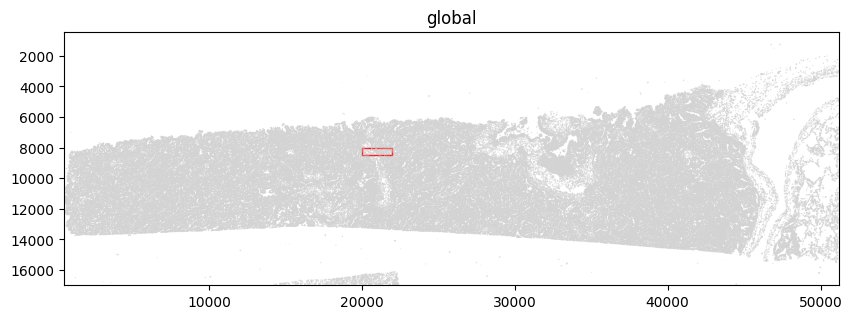

In [6]:
fig, ax = plt.subplots(figsize=(10, 10))
sdata.pl.render_shapes().pl.show(ax=ax)
rect = patches.Rectangle((20000, 8000), 2000, 500, linewidth=1, edgecolor="red", facecolor="none")
ax.add_patch(rect)

We will now, select all spatial elements within this red rectangular box and plot the corresponding H&E image, Morphology and Cell labels. You can play around with the box coordinates by defining a new ```crop1``` function.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.011904762..1.0].


INFO     Rasterizing image for faster rendering.                                                                   


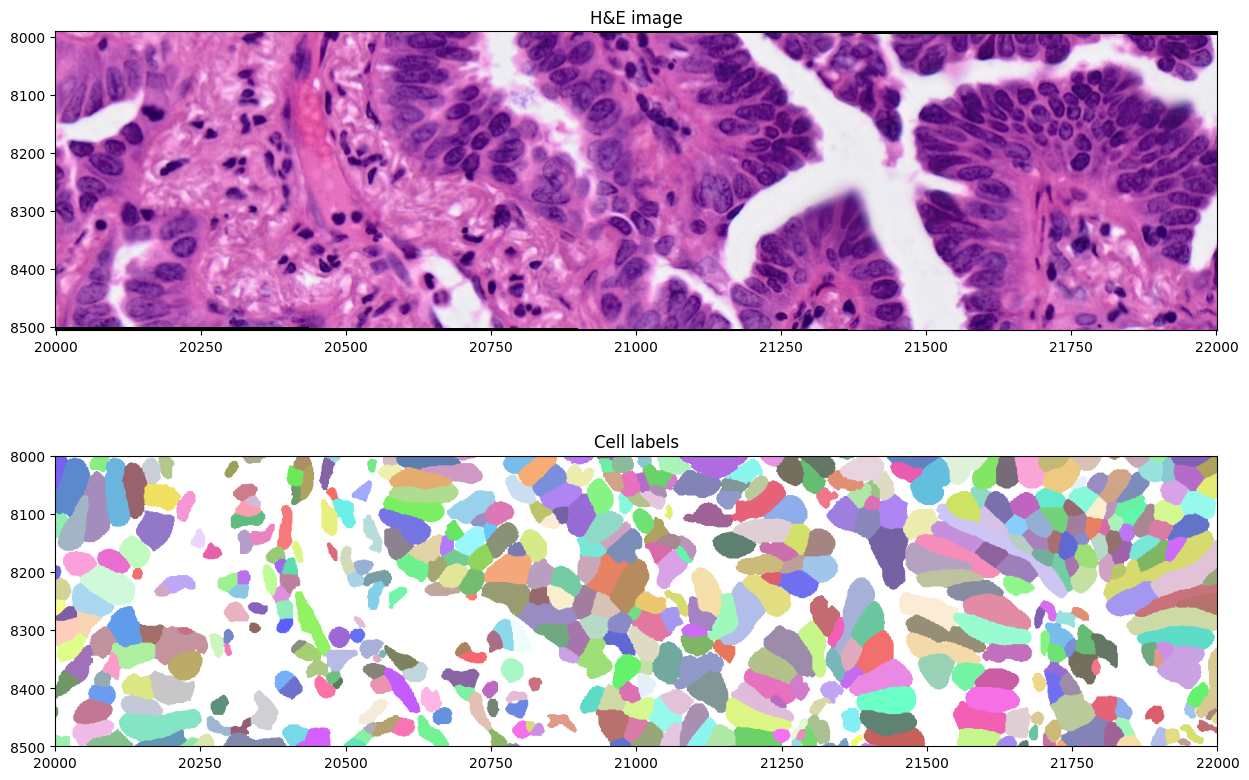

In [7]:
axes = plt.subplots(2, 1, figsize=(15, 10))[1].flatten()

def crop0(x):
    return bounding_box_query(
        x,
        min_coordinate=[20_000, 8000],
        max_coordinate=[22_000, 8500],
        axes=("x", "y"),
        target_coordinate_system="global",
    )


crop0(sdata).pl.render_images("he_image").pl.show(ax=axes[0], title="H&E image", coordinate_systems="global")
crop0(sdata).pl.render_labels("cell_labels").pl.show(ax=axes[1], title="Cell labels", coordinate_systems="global")

**Task 1** Plot the H&E, cell labels and one feature of your choice of your cropped version in one plot.

## Vectorization of labels into shapes

Another function in SpatialData is vectorization, e.g. transforming labels into shapes. For instance, we could transfer our cell labels to polygons or circles, reflecting abstract representation of cells, which we could use to aggregate our data.

INFO     Rasterizing image for faster rendering.                                                                   
INFO     Rasterizing image for faster rendering.                                                                   
INFO     Rasterizing image for faster rendering.                                                                   
INFO     Rasterizing image for faster rendering.                                                                   


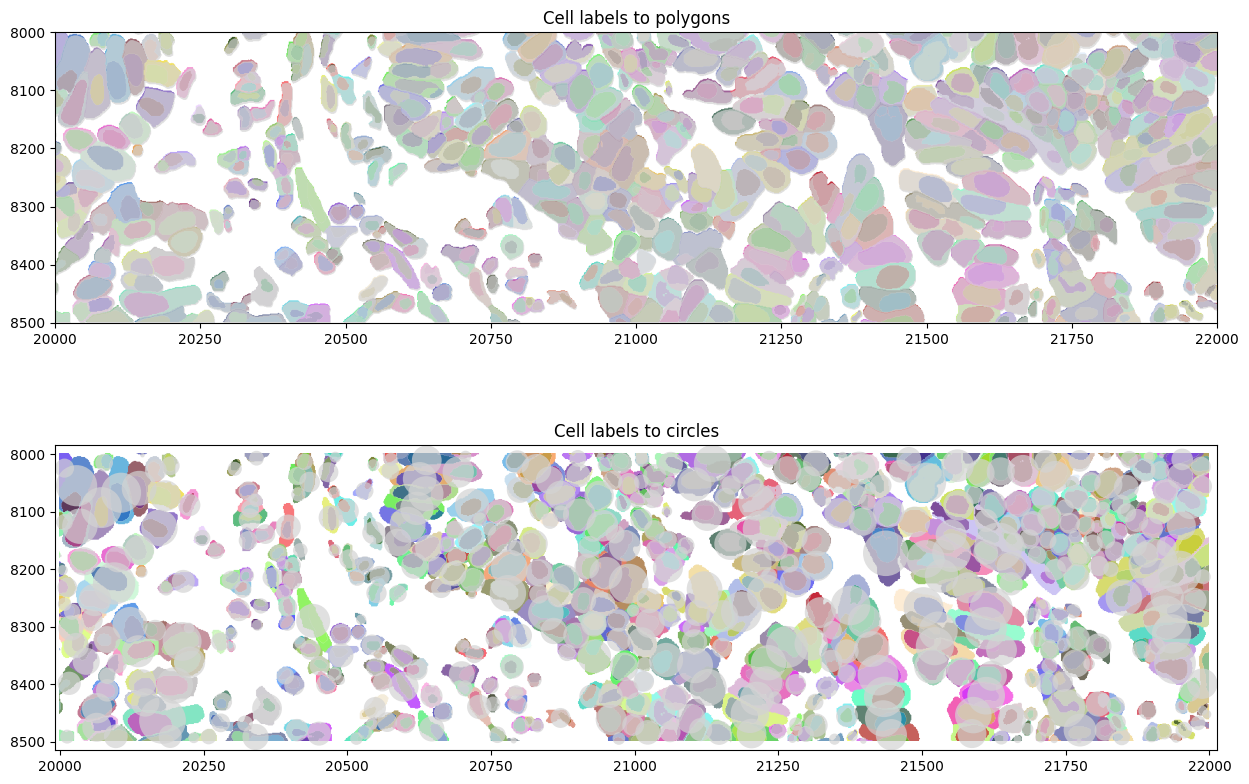

In [9]:
axes = plt.subplots(2, 1, figsize=(15, 10))[1].flatten()

cropped_sdata = crop0(sdata)

cropped_sdata["vectorized"] = to_polygons(cropped_sdata["cell_labels"])
cropped_sdata["circles"] = to_circles(cropped_sdata["cell_labels"])

cropped_sdata.pl.render_labels().pl.render_shapes("vectorized", outline=True, fill_alpha=0.7).pl.show(ax=axes[0], title = "Cell labels to polygons")
cropped_sdata.pl.render_labels().pl.render_shapes("circles", outline=True, fill_alpha=0.7).pl.show(ax=axes[1], title="Cell labels to circles")

**Task 1**: When would you.use circles vs. polygons? Think about when this vectorization could be useful for your data analysis.

## Aggregating your data

Sometimes you have multiple experiments, yielding different resolutions, Xenium and Visium experiments, respectively. To have better comparability, the data needs to be adapted, e.g. binning the higher resolution data. In this part, we will create a hexagonal grid and aggregate our cells, basically binning our data.


In this first part, we will create a hexagonal grid, plot it and extract the x, y coordinates.

In [10]:
import numpy as np
from geopandas import GeoDataFrame
from shapely.geometry import Polygon
from spatialdata.models import ShapesModel
from spatialdata import get_extent

extent = get_extent(sdata)

def make_hexagonal_grid(x_min: float, x_max: float, y_min: float, y_max: float, n_cells_x, n_cells_y) -> GeoDataFrame:
    x_hex_size = (x_max - x_min) / (n_cells_x * 3 / 2)
    y_hex_size = (y_max - y_min) / (n_cells_y * np.sqrt(3))

    grid = []

    for i in range(n_cells_x):
        for j in range(n_cells_y):
            x_offset = i * 3 / 2 * x_hex_size
            y_offset = j * np.sqrt(3) * y_hex_size

            # offset every other column
            if i % 2 == 1:
                y_offset += np.sqrt(3) / 2 * y_hex_size

            # create a hexagon
            hexagon = Polygon(
                [
                    (x_offset, y_offset),
                    (x_offset + x_hex_size / 2, y_offset + np.sqrt(3) / 2 * y_hex_size),
                    (x_offset + x_hex_size * 3 / 2, y_offset + np.sqrt(3) / 2 * y_hex_size),
                    (x_offset + x_hex_size * 2, y_offset),
                    (x_offset + x_hex_size * 3 / 2, y_offset - np.sqrt(3) / 2 * y_hex_size),
                    (x_offset + x_hex_size / 2, y_offset - np.sqrt(3) / 2 * y_hex_size),
                    (x_offset, y_offset),
                ]
            )
            grid.append(hexagon)

    grid_gdf = GeoDataFrame(grid, columns=["geometry"])
    return ShapesModel.parse(grid_gdf)

hexagonal_grid_gdf = make_hexagonal_grid(
    x_min=extent["x"][0],
    x_max=extent["x"][1],
    y_min=extent["y"][0],
    y_max=extent["y"][1],
    n_cells_x=20,
    n_cells_y=20,
)

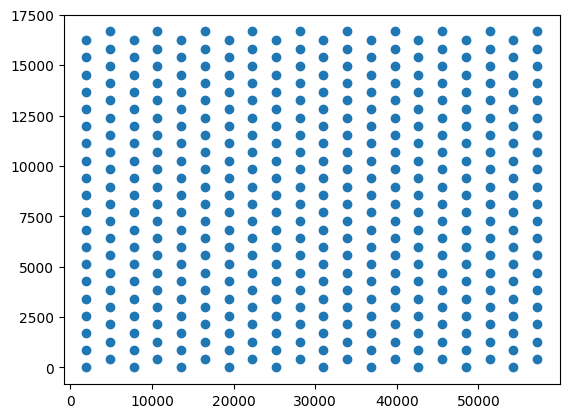

In [11]:
hex_coords = np.hstack(
    [hexagonal_grid_gdf.geometry.centroid.x.to_numpy().reshape(-1, 1),
    hexagonal_grid_gdf.geometry.centroid.y.to_numpy().reshape(-1, 1)]
)
plt.scatter(
    x = hex_coords[:, 0],
    y = hex_coords[:, 1],
)


We can now add the hexagonal grid to the SpatialData object and use the ```aggregate``` function to bin our data. You can try different value keys (genes) to aggregate.

INFO     Using 'datashader' backend with 'None' as reduction method to speed up plotting. Depending on the         
         reduction method, the value range of the plot might change. Set method to 'matplotlib' do disable this    
         behaviour.                                                                                                
INFO     Using the datashader reduction "mean". "max" will give an output very close to the matplotlib result.     


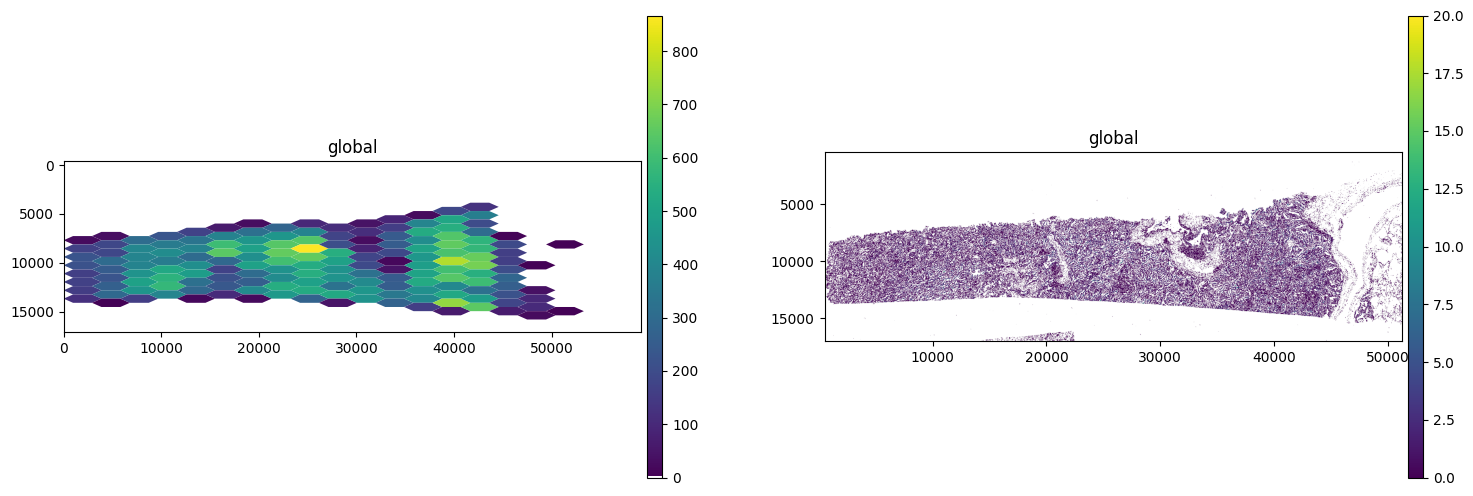

In [12]:
sdata["hexagonal_grid"] = hexagonal_grid_gdf

fig, axs = plt.subplots(1, 2, figsize=(18, 6))
new_cmap = set_zero_in_cmap_to_transparent(cmap="viridis")

(
    sdata.aggregate(values="cell_circles", by="hexagonal_grid", value_key="ACE2")
    .pl.render_shapes("hexagonal_grid", color="ACE2", cmap=new_cmap)
    .pl.show(ax=axs[0])
)
sdata.pl.render_shapes("cell_circles", color="ACE2").pl.show(ax=axs[1])

**Task 1**: Bin for every feature, and extract an AnnData Table from this aggregated SpatialData instance and save it in our data folder

## Apply functions that directly work on SpatialData Tables (AnnData objects)

From previous tutorial, you have learned how to use [squidpy](https://squidpy.readthedocs.io/en/stable/), a tool specialized for visualising and analysing spatial omics datasets. Squidpy and SpatialData (and also AnnData) belong to the [scverse](https://scverse.org), an ecosystem of packages, that tackle challenges in spatial omics, regulatory genomics, trajectory inference, visualization, and more. Another package, that is widely used in the single cell field is [scanpy](https://scanpy.readthedocs.io/en/latest/) which provides functions for *data preprocessing, dimensional reduction, clustering and differential gene expression*.

Since, all mentioned packages belong to the same ecosystem, it makes workflows seamless: you can run preprocessing or clustering with scanpy, then immediately use squidpy’s spatial neighborhood analysis, all within your SpatialData object.

**Task 1**: Summarize the main advantages of each package and the main use cases.

**Task 2** Normalize your data and compute the highly variable genes using scanpy and plot the expression of one highly variable gene on top of the H&E image using SpatialData (Hint: check out this basic preprocessing [scanpy tutorial](https://scanpy.readthedocs.io/en/stable/tutorials/basics/clustering.html#normalization)).

**Task 3** Select MALL and plot the expression on top of the H&E image. What can you observe? Can you say something about the MALL expression pattern? Maybe google the function of it.

**Task 4**: Compute one spatial statistics of your choice using squidpy (Check: out the previous tutorial).

**Task 5** Select one hvg gene of your choice and plot H&E, transcript location and cell labels into one plot.